In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from skimage import color, filters, measure, morphology, transform
from scipy import ndimage
from scipy.stats import skew, kurtosis 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from itertools import cycle
plt.style.use('ggplot')
sns.set_style("whitegrid")
SEED = 42
np.random.seed(SEED)

In [2]:
df = pd.read_csv('Datos/HAM10000_metadata')
image_path_map = {os.path.splitext(os.path.basename(x))[0]: x 
                  for x in glob(os.path.join('.', '**', '*.jpg'), recursive=True)}
df['path'] = df['image_id'].map(image_path_map.get)
df = df.dropna(subset=['path'])
print(f"Total imágenes: {len(df)}")
print(df['dx'].value_counts())

Total imágenes: 10015
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [8]:
def segmentacion(img_rgb):
    """Método 1: Básico (Escala de grises + Otsu Global)"""
    gris = color.rgb2gray(img_rgb)
    thresh = filters.threshold_otsu(gris)
    return gris < thresh 

def segmentacion_col(img_rgb):
    """
    Método 2: Avanzado (Propuesto en PDF Metodos_segmentacion)
    - Espacio de Color HSV (Canal S)
    - Operaciones morfológicas para limpiar ruido
    """
    img_hsv = color.rgb2hsv(img_rgb)
    s_channel = img_hsv[:, :, 1]
    
    try:
        thresh = filters.threshold_otsu(s_channel)
        mask = s_channel > thresh
    except:
        return np.zeros(s_channel.shape, dtype=bool)
        
    mask = morphology.closing(mask, morphology.disk(3))
    mask = morphology.opening(mask, morphology.disk(3))
    
    labels = measure.label(mask)
    if labels.max() == 0: return mask
    largest = labels == np.argmax(np.bincount(labels.flat)[1:]) + 1
    return ndimage.binary_fill_holes(largest)

def calcular_sim(mask1, mask2):
    """Métrica para comparar similitud entre dos segmentaciones"""
    interseccion = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    if np.sum(union) == 0: return 0
    return np.sum(interseccion) / np.sum(union)

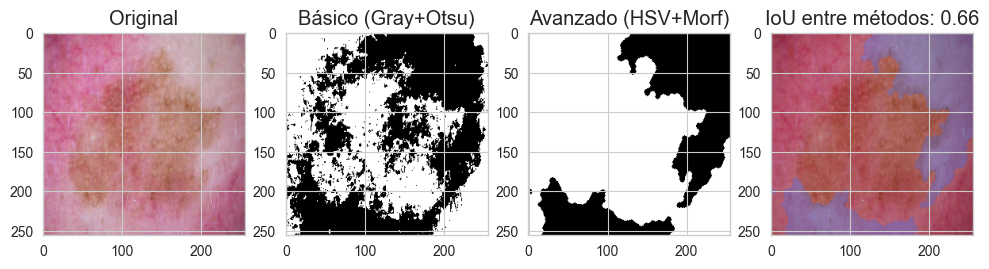

In [9]:
row = df.sample(1, random_state=SEED).iloc[0]
img = plt.imread(row['path'])
img = cv2.resize(img, (256, 256)) / 255.0

mask_basic = segmentacion(img)
mask_adv = segmentacion_col(img)
iou = calcular_sim(mask_basic, mask_adv)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1); plt.imshow(img); plt.title("Original")
plt.subplot(1, 4, 2); plt.imshow(mask_basic, cmap='gray'); plt.title("Básico (Gray+Otsu)")
plt.subplot(1, 4, 3); plt.imshow(mask_adv, cmap='gray'); plt.title("Avanzado (HSV+Morf)")
plt.subplot(1, 4, 4); plt.imshow(img); plt.imshow(mask_adv, alpha=0.3, cmap='jet'); plt.title(f"IoU entre métodos: {iou:.2f}")
plt.show()

In [16]:
def momento(px):
    if len(px) == 0: return [0, 0, 0, 0]
    m, s = np.mean(px), np.std(px)
    sk = skew(px) if s > 0 else 0
    ku = kurtosis(px) if s > 0 else 0
    return [m, s, sk, ku]

def variables(row):
    path = row['path']
    img = plt.imread(path)
    if len(img.shape) == 3 and img.shape[2] == 4:
        img = img[:, :, :3]
    img = cv2.resize(img, (128, 128))
    if img.max() > 1.0:
        img_norm = img / 255.0
    else:
        img_norm = img
    try:
        hsv = color.rgb2hsv(img_norm)
        s = hsv[:, :, 1]
        mask = s > filters.threshold_otsu(s)
        mask = morphology.closing(mask, morphology.disk(3))
        mask = morphology.opening(mask, morphology.disk(3))
    except:
        mask = np.zeros((128,128), dtype=bool)
    if np.sum(mask) < 50:
        gray = color.rgb2gray(img_norm)
        mask = gray < filters.threshold_otsu(gray)
        mask = morphology.opening(mask, morphology.disk(2))
    if np.sum(mask) < 10:
        mask = np.zeros((128,128), dtype=bool)
        mask[32:96, 32:96] = True 
    props = measure.regionprops(mask.astype(int))[0]
    eccentricity = props.eccentricity
    asym = props.eccentricity 
    compactness = (props.perimeter**2)/(4*np.pi*props.area) if props.area > 0 else 0
    solidity = props.solidity
    diameter = props.equivalent_diameter
    area = props.area
    
    feat_col = []
    img_lab = color.rgb2lab(img_norm)
    img_hsv = color.rgb2hsv(img_norm)
    for space in [img_norm, img_hsv, img_lab]:
        masked_px = space[mask]
        for ch in range(3):
            feat_col.extend(momento(masked_px[:, ch]))
            
    hist = cv2.calcHist([img_norm.astype('float32')], [0,1,2], mask.astype(np.uint8), [8]*3, [0,1]*3)
    n_colors = np.sum((hist/np.sum(hist)) > 0.005)
    
    return np.concatenate([
        [eccentricity, asym, compactness, solidity, diameter, area],
        feat_col, 
        [n_colors]
    ])
if not df.empty:
    print("\n3. Iniciando extracción de características...")
    data = []
    labels = []
    
    for i, row in tqdm(df.iterrows(), total=len(df)):
        feats = variables(row)
        data.append(feats)
        labels.append(row['dx'])
    cols = ['Eccentricity', 'Asymmetry', 'Compactness', 'Solidity', 'Diameter', 'Area']
    for s in ['RGB', 'HSV', 'LAB']:
        for c in range(3):
            for m in ['Mean', 'Std', 'Skew', 'Kurt']:
                cols.append(f"{s}_Ch{c}_{m}")
    cols.append('Dom_Colors')
    X = pd.DataFrame(data, columns=cols)
    y = np.array(labels)


3. Iniciando extracción de características...


100%|██████████| 10015/10015 [06:37<00:00, 25.20it/s]


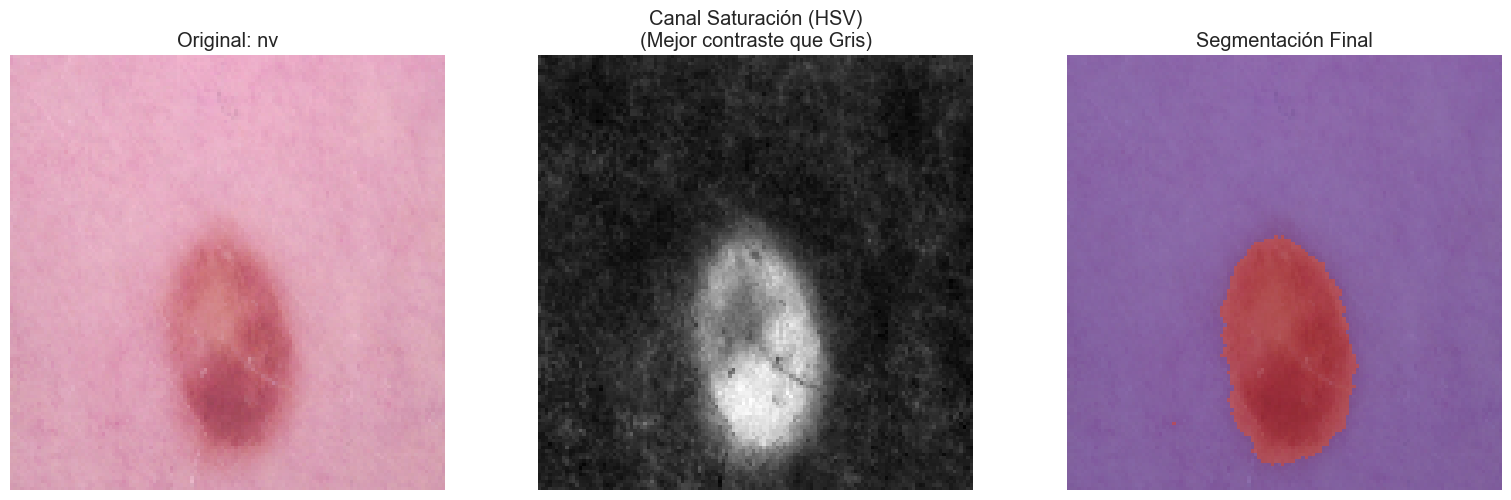

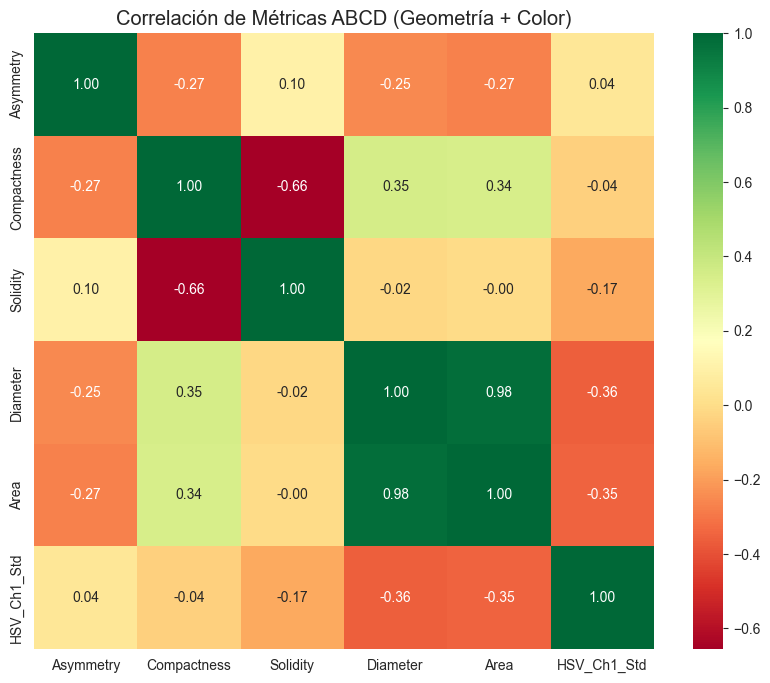

C:\Users\lande\AppData\Local\Temp\ipykernel_5968\3862065039.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnóstico', y='Diameter', data=df_eda, palette="Set3", ax=axes[0])
C:\Users\lande\AppData\Local\Temp\ipykernel_5968\3862065039.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnóstico', y='HSV_Ch1_Std', data=df_eda, palette="coolwarm", ax=axes[1])


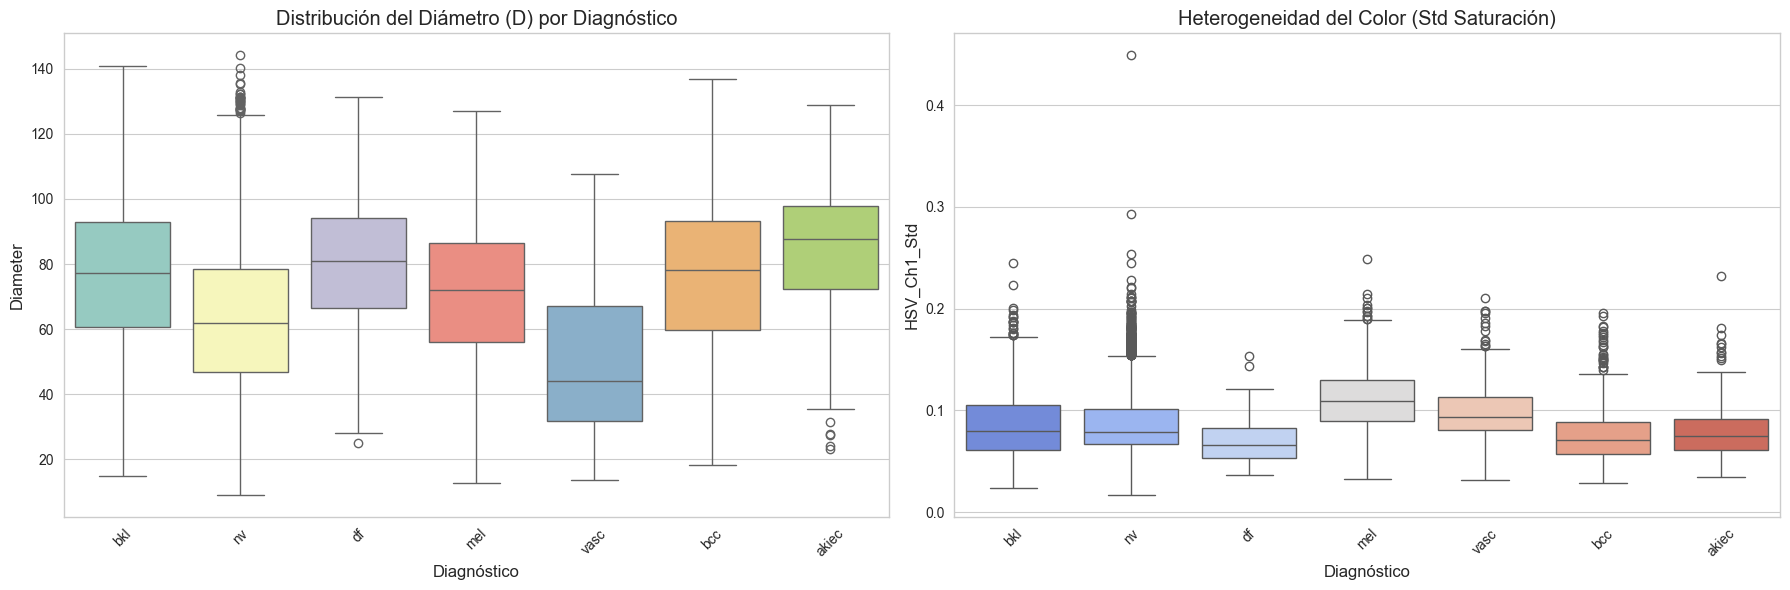

In [17]:
sample_row = df.sample(1).iloc[0]
img_path = sample_row['path']
dx_label = sample_row['dx']

img = plt.imread(img_path)
if img.shape[-1] == 4: img = img[:,:,:3]
img = cv2.resize(img, (128, 128))
if img.max() > 1.0: img_norm = img / 255.0
else: img_norm = img

img_hsv = color.rgb2hsv(img_norm)
s_channel = img_hsv[:, :, 1]
thresh = filters.threshold_otsu(s_channel)
mask = s_channel > thresh
mask = morphology.closing(mask, morphology.disk(3)) 

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].imshow(img_norm)
ax[0].set_title(f"Original: {dx_label}")
ax[0].axis('off')
ax[1].imshow(s_channel, cmap='gray')
ax[1].set_title("Canal Saturación (HSV)\n(Mejor contraste que Gris)")
ax[1].axis('off')
ax[2].imshow(img_norm)
ax[2].imshow(mask, cmap='jet', alpha=0.4) 
ax[2].set_title("Segmentación Final")
ax[2].axis('off')
plt.tight_layout()
plt.show()

df_eda = X.copy()
df_eda['Diagnóstico'] = y
cols_eda = ['Asymmetry', 'Compactness', 'Solidity', 'Diameter', 'Area', 
            'HSV_Ch1_Std'] 
plt.figure(figsize=(10, 8))
sns.heatmap(df_eda[cols_eda].corr(), annot=True, cmap='RdYlGn', fmt=".2f")
plt.title("Correlación de Métricas ABCD (Geometría + Color)")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(x='Diagnóstico', y='Diameter', data=df_eda, palette="Set3", ax=axes[0])
axes[0].set_title("Distribución del Diámetro (D) por Diagnóstico")
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Diagnóstico', y='HSV_Ch1_Std', data=df_eda, palette="coolwarm", ax=axes[1])
axes[1].set_title("Heterogeneidad del Color (Std Saturación)")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

1. Optimizando Random Forest (GridSearch)...
   -> RF CV Accuracy: 0.7458 (+/- 0.0026)

2. Optimizando SVM (GridSearch)...
   -> SVM CV Accuracy: 0.6791 (+/- 0.0075)

3. Optimizando KNN (GridSearch)...
   -> KNN CV Accuracy: 0.7299 (+/- 0.0090)

4. Optimizando Gradient Boosting (GridSearch)...
   -> GB CV Accuracy: 0.7444 (+/- 0.0068)

Resultados: Random Forest
              precision    recall  f1-score   support

       akiec       0.49      0.35      0.41        65
         bcc       0.56      0.47      0.51       103
         bkl       0.50      0.29      0.36       220
          df       1.00      0.04      0.08        23
         mel       0.54      0.29      0.38       223
          nv       0.79      0.95      0.86      1341
        vasc       1.00      0.43      0.60        28

    accuracy                           0.74      2003
   macro avg       0.70      0.40      0.46      2003
weighted avg       0.71      0.74      0.71      2003



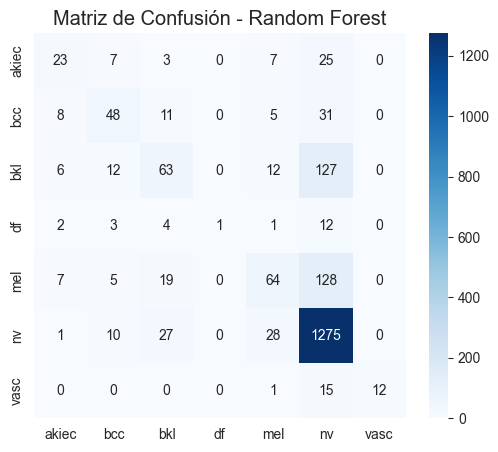


Resultados: SVM
              precision    recall  f1-score   support

       akiec       0.39      0.65      0.48        65
         bcc       0.50      0.54      0.52       103
         bkl       0.42      0.59      0.49       220
          df       0.26      0.30      0.28        23
         mel       0.41      0.60      0.48       223
          nv       0.94      0.76      0.84      1341
        vasc       0.96      0.79      0.86        28

    accuracy                           0.71      2003
   macro avg       0.55      0.61      0.57      2003
weighted avg       0.78      0.71      0.73      2003



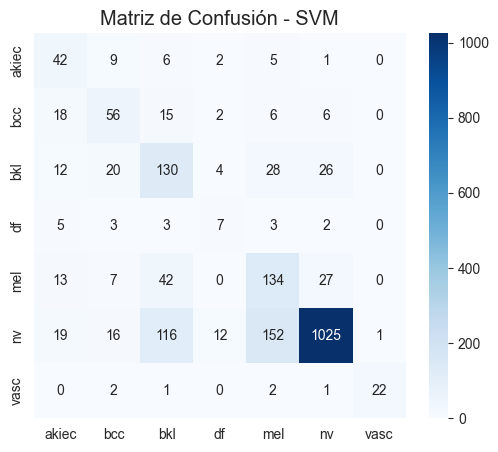


Resultados: KNN
              precision    recall  f1-score   support

       akiec       0.38      0.37      0.37        65
         bcc       0.58      0.39      0.47       103
         bkl       0.40      0.37      0.39       220
          df       0.45      0.22      0.29        23
         mel       0.46      0.31      0.37       223
          nv       0.83      0.92      0.87      1341
        vasc       1.00      0.43      0.60        28

    accuracy                           0.73      2003
   macro avg       0.59      0.43      0.48      2003
weighted avg       0.71      0.73      0.72      2003



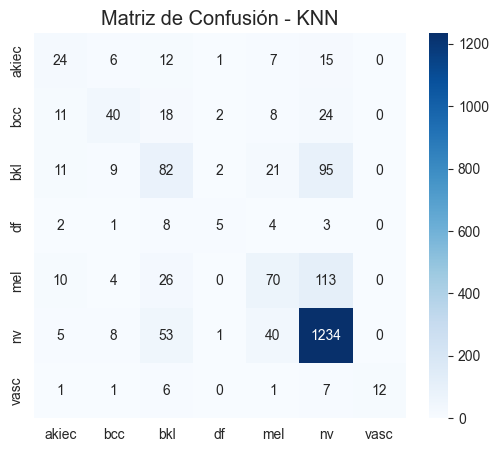


Resultados: Gradient Boosting
              precision    recall  f1-score   support

       akiec       0.29      0.18      0.22        65
         bcc       0.60      0.45      0.51       103
         bkl       0.50      0.43      0.46       220
          df       0.38      0.13      0.19        23
         mel       0.52      0.35      0.41       223
          nv       0.82      0.94      0.88      1341
        vasc       0.93      0.46      0.62        28

    accuracy                           0.75      2003
   macro avg       0.58      0.42      0.47      2003
weighted avg       0.72      0.75      0.73      2003



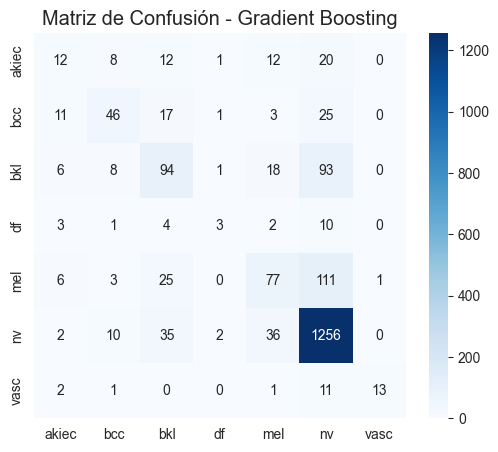


Generando Curvas ROC Comparativas...


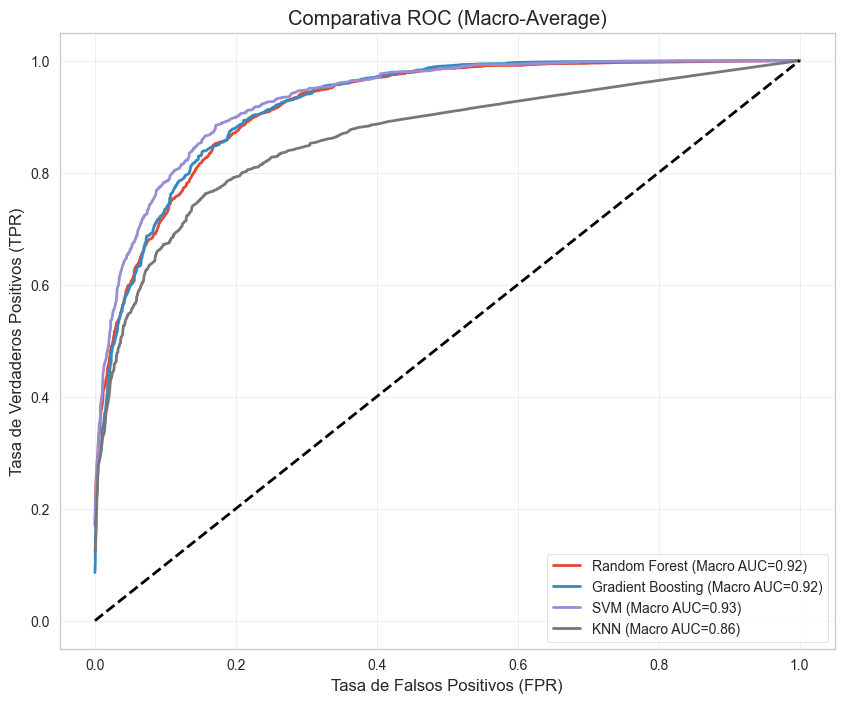

In [32]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=SEED)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# MODELO 1: Random Forest
rf = RandomForestClassifier(random_state=SEED, class_weight='balanced')
param_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
print("1. Optimizando Random Forest (GridSearch)...")
grid_rf = GridSearchCV(rf, param_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
cv_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=5)
print(f"   -> RF CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

# MODELO 2: Support Vector Machine (SVM)
svm = SVC(probability=True, random_state=SEED, class_weight='balanced')
param_svm = {'C': [1, 10], 'kernel': ['rbf']} 
print("\n2. Optimizando SVM (GridSearch)...")
grid_svm = GridSearchCV(svm, param_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_sc, y_train)
best_svm = grid_svm.best_estimator_
cv_scores_svm = cross_val_score(best_svm, X_train_sc, y_train, cv=5)
print(f"   -> SVM CV Accuracy: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std():.4f})")

# MODELO 3: K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
param_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
print("\n3. Optimizando KNN (GridSearch)...")
grid_knn = GridSearchCV(knn, param_knn, cv=3, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_sc, y_train)
best_knn = grid_knn.best_estimator_
cv_scores_knn = cross_val_score(best_knn, X_train_sc, y_train, cv=5)
print(f"   -> KNN CV Accuracy: {cv_scores_knn.mean():.4f} (+/- {cv_scores_knn.std():.4f})")

# MODELO 4: Gradient Boosting
gb = GradientBoostingClassifier(random_state=SEED)
param_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1], 
    'max_depth': [3, 5]
}
print("\n4. Optimizando Gradient Boosting (GridSearch)...")
grid_gb = GridSearchCV(gb, param_gb, cv=3, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_
cv_scores_gb = cross_val_score(best_gb, X_train, y_train, cv=5)
print(f"   -> GB CV Accuracy: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std():.4f})")

import sklearn.metrics as skm
def resultados(model, X_set, y_true, name):
    print(f"\nResultados: {name}")
    y_pred = model.predict(X_set)
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()

resultados(best_rf, X_test, y_test, "Random Forest")
resultados(best_svm, X_test_sc, y_test, "SVM")
resultados(best_knn, X_test_sc, y_test, "KNN")
resultados(best_gb, X_test, y_test, "Gradient Boosting")

y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]
def graficar_roc_seguro(model, X_val, label_name):
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_val)
        else:
            y_prob = model.decision_function(X_val)
    except:
        print(f"Advertencia: No se puede calcular ROC para {label_name}")
        return
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = skm.roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = skm.auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    auc_macro = skm.auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f'{label_name} (Macro AUC={auc_macro:.2f})', lw=2)
print("\nGenerando Curvas ROC Comparativas...")
plt.figure(figsize=(10, 8))
graficar_roc_seguro(best_rf, X_test, "Random Forest")
graficar_roc_seguro(best_gb, X_test, "Gradient Boosting")
graficar_roc_seguro(best_svm, X_test_sc, "SVM") 
graficar_roc_seguro(best_knn, X_test_sc, "KNN") 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparativa ROC (Macro-Average)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Generando ROC detallado para Random Forest...


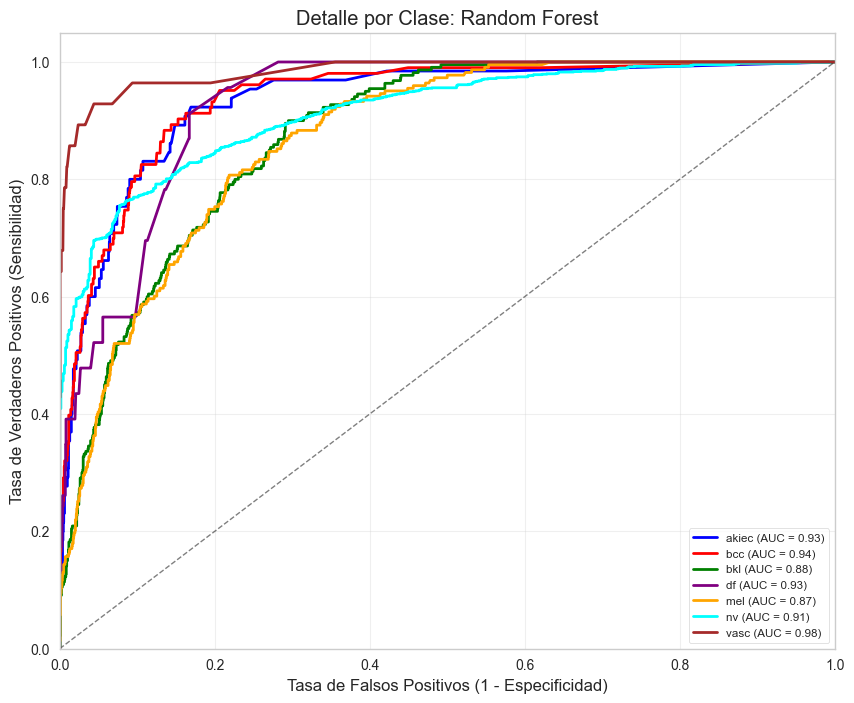

Generando ROC detallado para SVM...


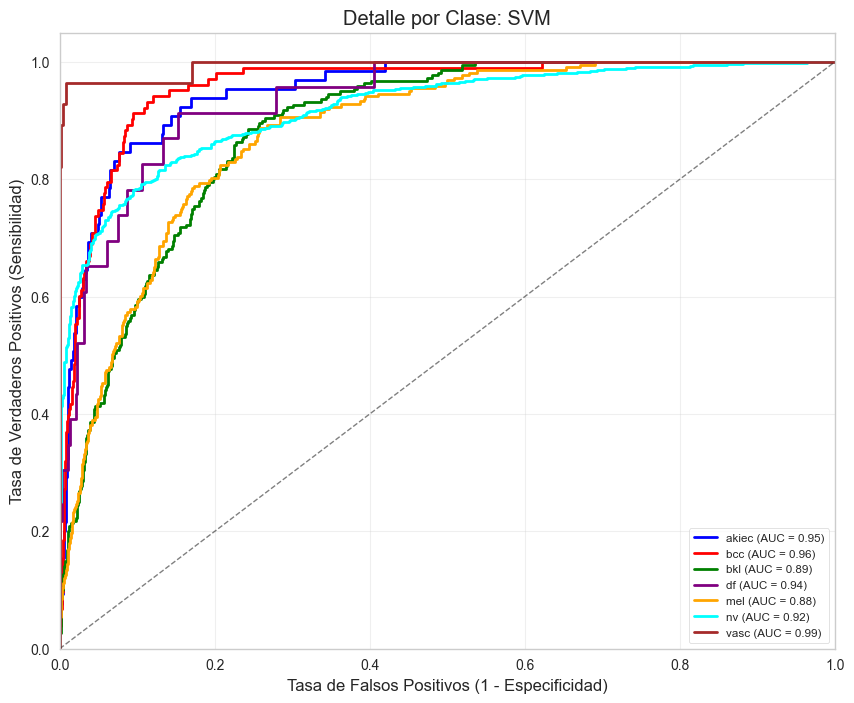

Generando ROC detallado para K-Nearest Neighbors...


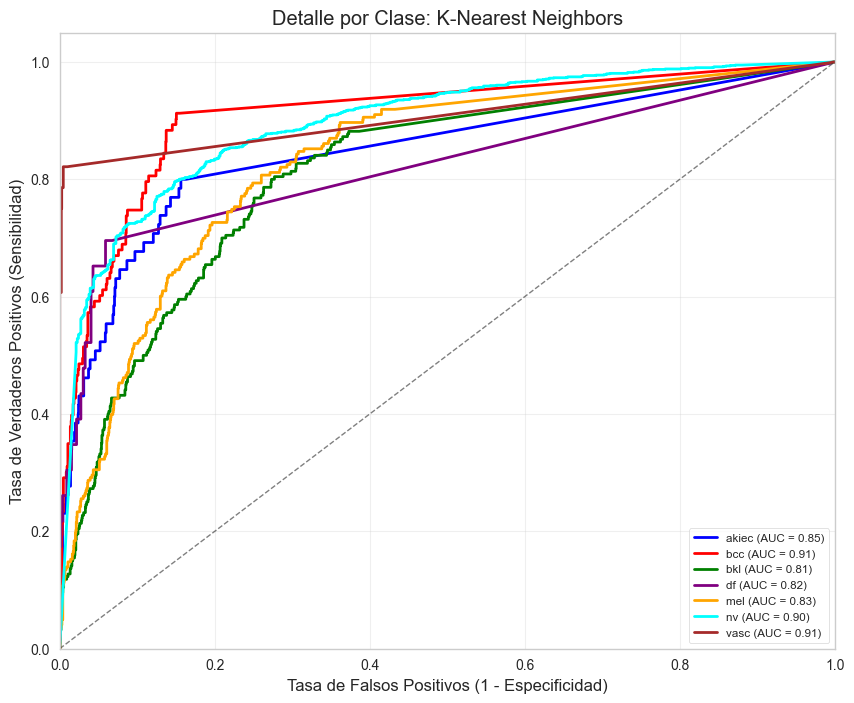

Generando ROC detallado para Gradient Boosting...


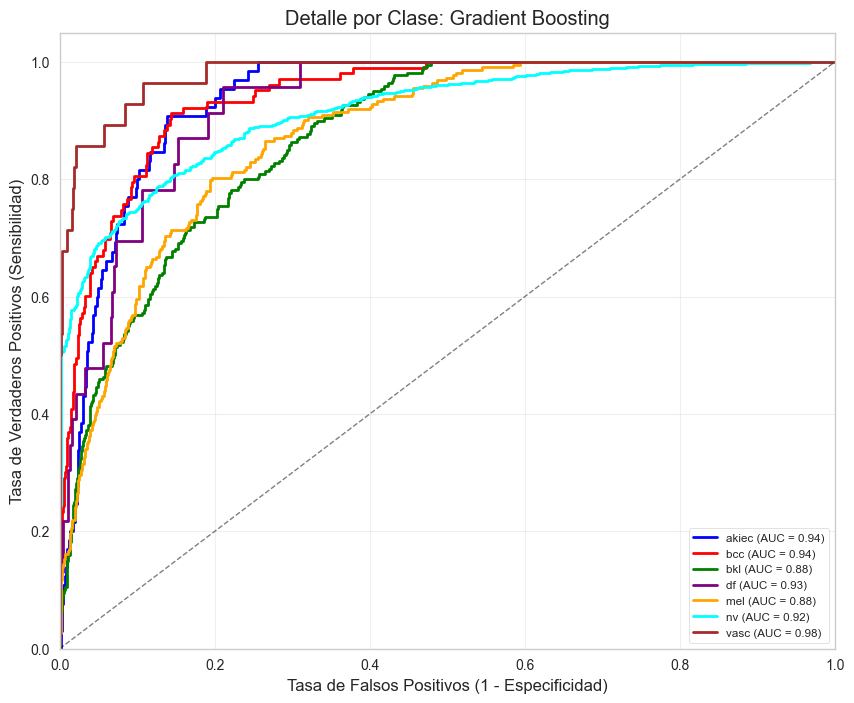

In [33]:
def roc_clase_seguro(model, X_set, y_test, model_name):
    """
    Genera un gráfico ROC con una curva por cada clase para un modelo específico.
    Versión segura contra conflictos de nombres.
    """
    try:
        y_score = model.predict_proba(X_set)
    except AttributeError:
        y_score = model.decision_function(X_set)
    n_classes = len(le.classes_)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'brown'])
    print(f"Generando ROC detallado para {model_name}...")
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = skm.roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = skm.auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
    plt.title(f'Detalle por Clase: {model_name}')
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(True, alpha=0.3)
    plt.show()

roc_clase_seguro(best_rf, X_test, y_test, "Random Forest")
roc_clase_seguro(best_svm, X_test_sc, y_test, "SVM") 
roc_clase_seguro(best_knn, X_test_sc, y_test, "K-Nearest Neighbors")
roc_clase_seguro(best_gb, X_test, y_test, "Gradient Boosting")

### Selección del Modelo Final

Tras analizar las métricas de evaluación, seleccionamos el **Gradient Boosting** como el modelo final para el despliegue.

**Justificación Clínica y Técnica:**
1.  **Mayor Sensibilidad en Melanoma:** El Gradient Boosting presentó un recall de **0.35** para la clase `mel`, superando al Random Forest (0.29). Dado que el melanoma es la patología con mayor tasa de mortalidad, priorizamos el modelo que minimiza los falsos negativos en esta clase.
2.  **Mejor F1-Score Ponderado:** Con un valor de **0.73**, demuestra una mejor capacidad de generalización en las clases intermedias (como `bkl` y `vasc`) en comparación con el 0.71 del Random Forest.
3.  **Robustez:** Mantuvo una accuracy del 75% en el conjunto de test, validando que no ha sufrido sobreajuste (overfitting) significativo respecto a la validación cruzada (0.744).

**Limitaciones detectadas:**
Se observa que ambos modelos presentan dificultades para clasificar correctamente las lesiones vasculares (`vasc`) y dermatofibromas (`df`) debido a su bajísima prevalencia en el dataset original, a pesar del uso de pesos balanceados.

C:\Users\lande\AppData\Local\Temp\ipykernel_5968\4135340220.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[cols[i] for i in idx], y=imp[idx], palette='viridis')


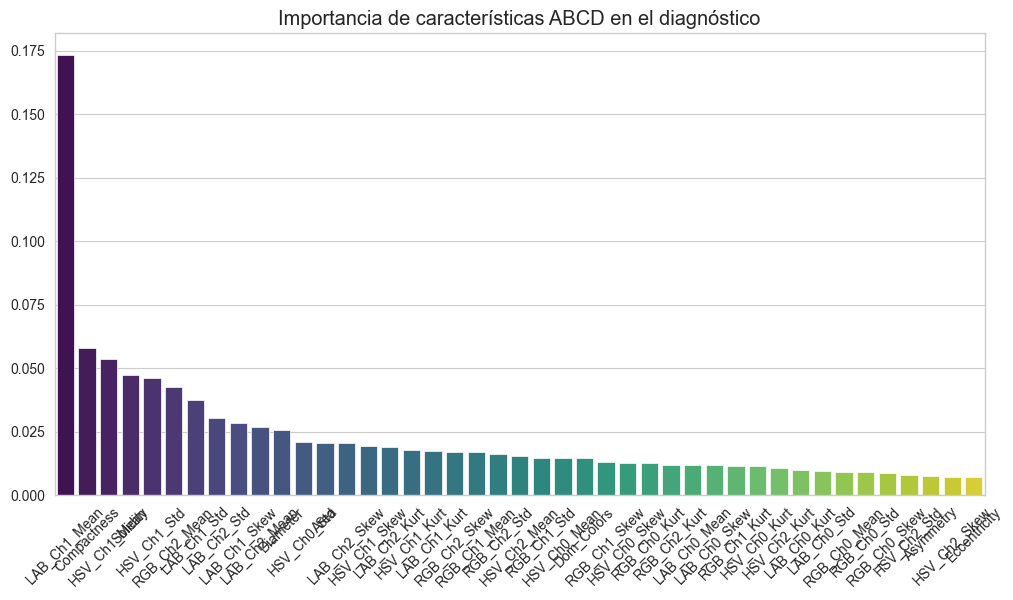

In [34]:
imp = best_gb.feature_importances_
idx = np.argsort(imp)[::-1]
plt.figure(figsize=(12, 6))
sns.barplot(x=[cols[i] for i in idx], y=imp[idx], palette='viridis')
plt.xticks(rotation=45)
plt.title("Importancia de características ABCD en el diagnóstico")
plt.show()